In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from smodels.decomposition.theorySMS import TheorySMS
from smodels.experiment.expSMS import ExpSMS
from smodels.share.models.mssm import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.experiment.defaultFinalStates import finalStates
from smodels.base.model import Model
from collections import OrderedDict
from smodels.base.physicsUnits import fb, GeV
from itertools import product
from smodels.experiment.databaseObj import Database
import copy
import re
from smodels.base.smodelsLogging import logger
import plotly.graph_objects as go

logger.setLevel('ERROR')

In [2]:
def convertAxesStr(inStr):
    entryDict = {}
    # First find the outermost enclosing brackets:
    iLeft = inStr.find('[')
    iRight = inStr.rfind(']')+1
    newStr = inStr[iLeft:iRight]
    # Remove blank spaces:
    newStr = newStr.replace(" ","")
    iel = 0
    # Loop over the string and replace entries by
    # "Xi" strings
    for x in re.split(r',\s*(?![^()]*\))', newStr):
        x = x.replace('[','').replace(']','')
        x = x.strip()
        if not x in entryDict:
            entryDict[x] = "'X%i'" %iel
            iel += 1
        xNew = entryDict[x]
        # print('x=',x,'xNew=',xNew)
        # print('before=',newStr)
        newStr = newStr.replace(x,xNew,1)
        # print('after=',newStr)
    # Add the original enclosing strings 
    # (for cases where the string ends in ]]*2)
    newStr = inStr[:iLeft]+newStr+inStr[iRight:]
    # print('final=',newStr)
    # Evaluate the string with the entries replaces
    # by Xi strings:
    axes = eval(newStr)
    
    return axes

def getAxesSMS(txAxes):
    """
    Generates a dummy SMS with nodes holding axis labels.
    """
    axesSMS = []
    if isinstance(txAxes,str):
        txAxes = [txAxes]
    for txAx in txAxes:
        axis = convertAxesStr(txAx)
        axisStr = str([[['anySM'] for ptc in br[:-1]] for br in axis])
        finalStates = [str(br[-1]) for br in axis]
        intermediateStates = [[str(ptc) for ptc in br[:-1]] for br in axis]
        axSMS = ExpSMS.from_string(axisStr,finalState=finalStates,
                                intermediateState=intermediateStates)
        axesSMS.append(axSMS)
    
    return axesSMS

def symmetricAxes(txAxes):

    if isinstance(txAxes,str):
        txAxes = [txAxes]
    for txAx in txAxes:
        axis = convertAxesStr(txAx)
        if len(axis) != 2:
            # print('Found %i branches!' %(len(axis)))
            return False
        if axis[0] != axis[1]:
            # print('Non-symmetric axis:\n %s != %s' %(axis[0],axis[1]))
            return False

    return True


### Get database

In [3]:
db = Database('official')

In [4]:
databaseSMSDict = {}
uniqueSMSDict = {}
allSMS = []
for iexp,exp in enumerate(db.getExpResults()):
    expID = exp.globalInfo.id
    for ids,dataset in enumerate(exp.datasets):
        dsID = dataset.dataInfo.dataId
        for itx,tx in enumerate(dataset.txnameList):
            txID = str(tx)
            tx.sortSMSMap()
            for sms,smsLabel in tx.smsMap.items():
                allSMS.append(sms)
                smsMatch = None
                for sms1 in databaseSMSDict:
                    if sms.identicalTo(sms1):
                        smsMatch = sms1
                        break
                                
                # Update dictionary
                if smsMatch is None:
                    databaseSMSDict[sms] = {iexp : {ids : {itx : smsLabel}}}
                    uniqueSMSDict[sms] = {expID : {dsID : {txID : smsLabel}}}
                else:
                    useDict = databaseSMSDict[smsMatch]
                    entry = [iexp,ids,itx]
                    for key in entry:
                        if useDict.get(key) is None:
                            useDict.update({key : {}})
                        useDict = useDict.get(key)
                    useDict[itx] = smsLabel

                    if not expID in uniqueSMSDict[smsMatch]:
                        uniqueSMSDict[smsMatch].update({expID : {}})
                    if not dsID in  uniqueSMSDict[smsMatch][expID]:
                        uniqueSMSDict[smsMatch][expID].update({dsID : {}})
                    uniqueSMSDict[smsMatch][expID][dsID] = {txID : smsLabel}
                    

In [5]:
len(uniqueSMSDict),len(allSMS)

(206, 7186)

In [6]:
len(databaseSMSDict)

206

In [7]:
for sms in list(uniqueSMSDict.keys())[:3]:
    print(sms)
    anaList = list(uniqueSMSDict[sms].keys())
    txList = set([])
    for anaID in uniqueSMSDict[sms]:
        for dataID in uniqueSMSDict[sms][anaID]:
            for txID in uniqueSMSDict[sms][anaID][dataID]:
                txList.add(txID)
    print('\t %i analyses, %i txnames' %(len(anaList),len(txList)))
    print('\t Txnames = ',txList)
    print('\t Analyses = ',anaList)
    print('\n')

(PV > anyBSM(1),anyBSM(2)), (anyBSM(1) > MET,b), (anyBSM(2) > MET,b)
	 21 analyses, 1 txnames
	 Txnames =  {'T2bb'}
	 Analyses =  ['ATLAS-SUSY-2015-01', 'ATLAS-SUSY-2016-28', 'CMS-PAS-SUS-16-014', 'CMS-PAS-SUS-16-015', 'CMS-PAS-SUS-16-016', 'CMS-SUS-16-032', 'CMS-SUS-16-033', 'CMS-SUS-16-036', 'CMS-SUS-19-006', 'CMS-SUS-19-006-agg', 'ATLAS-CONF-2013-024', 'ATLAS-CONF-2013-047', 'ATLAS-CONF-2013-053', 'ATLAS-CONF-2013-054', 'ATLAS-CONF-2013-061', 'ATLAS-SUSY-2013-05', 'ATLAS-SUSY-2013-21', 'CMS-PAS-SUS-13-018', 'CMS-SUS-12-028', 'CMS-SUS-13-012', 'CMS-SUS-13-019']


(PV > anyBSM(1),anyBSM(2)), (anyBSM(1) > MET,t), (anyBSM(2) > MET,t)
	 41 analyses, 1 txnames
	 Txnames =  {'T2tt'}
	 Analyses =  ['ATLAS-SUSY-2015-02', 'ATLAS-SUSY-2016-15', 'ATLAS-SUSY-2016-16', 'ATLAS-SUSY-2016-17', 'ATLAS-SUSY-2018-08', 'ATLAS-SUSY-2018-12', 'CMS-PAS-SUS-16-014', 'CMS-PAS-SUS-16-015', 'CMS-PAS-SUS-16-016', 'CMS-SUS-16-009', 'CMS-SUS-16-033', 'CMS-SUS-16-036', 'CMS-SUS-16-049', 'CMS-SUS-16-050', 'CMS-SUS-

In [8]:
import networkx as nx

In [9]:
G = nx.from_dict_of_dicts(databaseSMSDict)

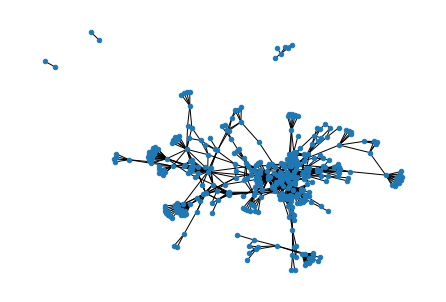

In [10]:
nx.draw(G,node_size=20)

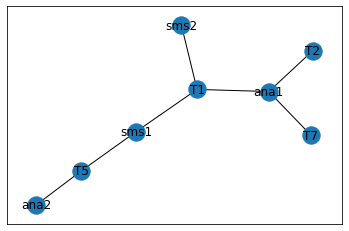

In [11]:
dd = {'sms1' : {'T1' : {} ,'T5' : {}},
      'sms2' : {'T1' : {}},
      'ana1' : {'T1' : {}, 'T2' : {},'T7' : {}},
      'ana2' : {'T5' : {}}}
G = nx.from_dict_of_dicts(dd)
nx.draw_networkx(G)